## Experimentation in progress

not great, because the 3x3 forward model is quite "unmovable". i.e. if we give as input a grid of values around 0.5, the model outputs values close to 0 all the time. I need the 3x3 model to be more susceptible to small changes. 

Check the new git branch "continuous_model"

also very slow method to calculate gradients. Anyway all of this is improved in "continuous model"

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from GenerateInput import generate_input
from LifeStepFunctions import life_step_for_tensors
from models import GameOfLifeModel

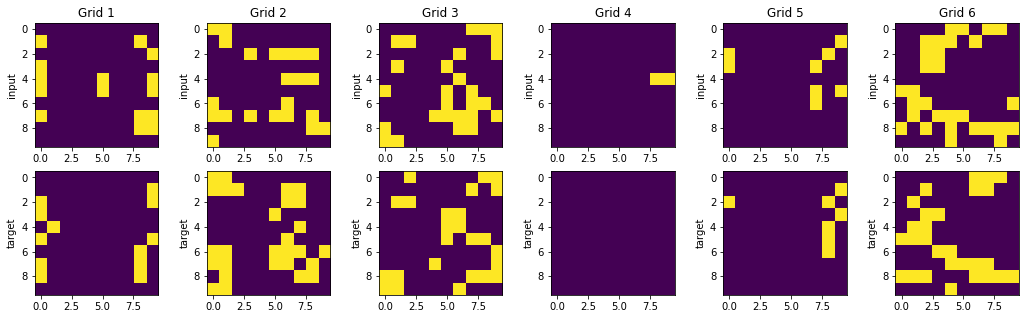

In [2]:
# generating some game states

x, y = generate_input(trials=8, grid_shape=(10,10),steps_before_generating_output=2)
y = tf.cast(y, dtype='float32')

plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')
    

In [3]:
model_3x3 = tf.keras.models.load_model('model_3x3')

class ComputeLoss(tf.keras.layers.Layer):
    
    def __init__(self, grid_size, target):
        super(ComputeLoss, self).__init__()
        self.grid_size = grid_size
        self.game_1_sample = GameOfLifeModel(grid_size, model_3x3)
        self.target_img = target
        self.mse = tf.keras.losses.MeanSquaredError()
    def call(self, input_img):
        input_img = tf.reshape(input_img, shape=(1,self.grid_size[0],self.grid_size[1]))
        target_img = tf.reshape(self.target_img, shape=(1,self.grid_size[0],self.grid_size[1]))

        output_img = self.game_1_sample(input_img)
        
        return self.mse(output_img, target_img)


class CalcGradients(tf.keras.layers.Layer):
    
    def __init__(self, grid_size, target, learning_rate):
        super(CalcGradients, self).__init__()
        self.target_img = target
        self.grid_size = grid_size
        self.compute_loss = ComputeLoss(self.grid_size, self.target_img)
        self.e = learning_rate

    def build(self, input_shape):
        self.grads = tf.Variable(tf.zeros(shape=self.grid_size), name='gradients', trainable=False, validate_shape=True)

        self.grid = tf.Variable(tf.zeros(shape=self.grid_size), name='computation_grid', trainable=False, validate_shape=True)
        super(CalcGradients, self).build(input_shape)
  
    def call(self, input_img):
        loss_0 = self.compute_loss(input_img)

        self.grid.assign(input_img)

        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                self.grid[i,j].assign(self.grid[i,j] + self.e)

                loss_ij = self.compute_loss(self.grid)
                self.grid[i,j].assign(self.grid[i,j]- self.e)

                self.grads[i,j].assign(loss_ij)  
        return self.grads



In [4]:
# exampe of how calc_gradients work. very sloww

input_img = tf.Variable(tf.random.uniform(shape=(10, 10), minval=0.4, maxval=0.6), name='input_image', trainable=True, validate_shape=True)

calc_gradients = CalcGradients((10,10), y[0], 0.2)
g =calc_gradients(input_img)


In [5]:
# showing how the forward model is "unmovable"

game_1_sample = GameOfLifeModel((10,10), model_3x3)

input_img = tf.Variable(tf.random.uniform(shape=(1,10, 10), minval=0.4, maxval=0.6), name='input_image', trainable=True, validate_shape=True)

x = game_1_sample(input_img)

x0 =tf.constant(x[0])
input_img[0,0,3].assign(1)
input_img[0,4,4].assign(1)
input_img[0,4,3].assign(1)
input_img[0,4,2].assign(1)

y = game_1_sample(input_img)
y0 = y[0]


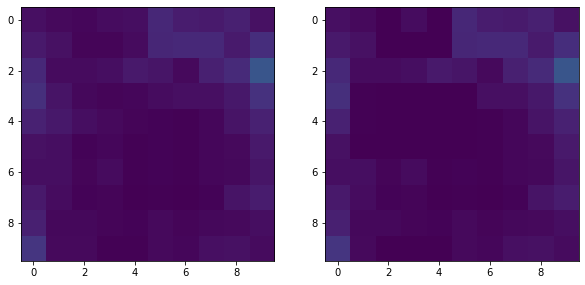

In [6]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(x0, vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.imshow(y[0], vmin=0, vmax=1)
